In [2]:
import keras
import sys
import math
import time
import glob
import numpy as np
from PIL import Image
import tensorflow as tf
from numpy import array
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv2D
from keras_vggface.vggface import VGGFace
from keras.models import Model, Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout

In [3]:
Imgs1 = sorted(glob.glob("Data/*.jpg"))

In [4]:
faces_imgs = np.load("faces_imgs.npy")
faces_annot = np.load("faces_annot.npy")[0]

In [5]:
def get_face_id(img):
    faces = []
    for i in faces_imgs:
        if i[1] == img:
            faces.append(i[0])
#     print(faces)
    return np.array(faces)

In [6]:
def get_id_coord(img):
#     print(img)
    W, H = Image.open(img).size
    coord = [] 
    ids = get_face_id(img[5:])
#     print(ids)
    for i in ids:
        if int(i) not in faces_annot.keys():
            return np.array([])
        coord.append(faces_annot[int(i)])
    a = np.array(coord, dtype=np.float32).reshape(-1, 4)
    a = a[a[:,0].argsort()]
    a[:, 0] = a[:, 0] /  W 
    a[:, 1] = a[:, 1] /  H 
    a[:, 2] = a[:, 2] /  W 
    a[:, 3] = a[:, 3] /  H 

    a = np.append(arr = np.ones((len(a), 1)), values= a, axis = 1).reshape(-1, 5)
    return a

In [7]:
Imgs = np.load("imgsFINAL.npy")[0]

In [ ]:
imgs = glob.glob("train/*/*.jpg")

In [ ]:
Imgs['train/0--Parade/0_Parade_Parade_0_181.jpg']

In [ ]:
def coord(imgName):
    W, H = Image.open(imgName).convert("RGB").size
    a = Imgs[imgName]
    a = a[a[:,1].argsort()]
    a[:, 1] = a[:, 1] /  W 
    a[:, 2] = a[:, 2] /  H 
    a[:, 3] = a[:, 3] /  W 
    a[:, 4] = a[:, 4] /  H 
    
    return a

In [7]:
K.set_learning_phase(1)
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)
sess = tf.Session()

X = tf.placeholder(dtype = tf.float32, shape = (1, None, None, 3))
Y = tf.placeholder(dtype = tf.float32, shape = (None, 5))

In [8]:
vgg = VGGFace(include_top=False, input_tensor = X, input_shape=(None, None, 3))
for layer in vgg.layers:
    layer.trainable = False

In [9]:
p1 = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same')(vgg.get_layer(index=11).output)
p1 = BatchNormalization()(p1)
p1 = Activation('relu')(p1)
p21 = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same')(vgg.get_layer(index=13).output)
p2 = BatchNormalization()(p21)
p2 = Activation('relu')(p2)

p101 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p1))
p102 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p1)

p201 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p2))
p202 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p2)


# DownSample

p1 = MaxPool2D(strides= 2)(p1)
p2 = MaxPool2D(strides= 2)(p2)

p1 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(p1)
p1 = BatchNormalization()(p1)
p1 = Activation('relu')(p1)
p2 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(p2)
p2 = BatchNormalization()(p2)
p2 = Activation('relu')(p2)

p111 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p1))
p112 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p1)

p211 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p2))
p212 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p2)

# DownSample

p1 = MaxPool2D(strides= 2)(p1)
p2 = MaxPool2D(strides= 2)(p2)

p1 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(p1)
p1 = BatchNormalization()(p1)
p1 = Activation('relu')(p1)
p2 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(p2)
p2 = BatchNormalization()(p2)
p2 = Activation('relu')(p2)

p121 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p1))
p122 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p1)

p221 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p2))
p222 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p2)

# DownSample

p1 = MaxPool2D(strides= 2)(p1)
p2 = MaxPool2D(strides= 2)(p2)

p1 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(p1)
p1 = BatchNormalization()(p1)
p1 = Activation('relu')(p1)
p2 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(p2)
p2 = BatchNormalization()(p2)
p2 = Activation('relu')(p2)

p131 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p1))
p132 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p1)

p231 = K.sigmoid(Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(p2))
p232 = Conv2D(filters=4, kernel_size=3, strides=1, padding='same')(p2)

# Combine All Predictions

p102 = K.concatenate(tensors=[p101, p102], axis = -1)
p202 = K.concatenate(tensors=[p201, p202], axis = -1)

p112 = K.concatenate(tensors=[p111, p112], axis = -1)
p212 = K.concatenate(tensors=[p211, p212], axis = -1)

p122 = K.concatenate(tensors=[p121, p122], axis = -1)
p222 = K.concatenate(tensors=[p221, p222], axis = -1)

p132 = K.concatenate(tensors=[p131, p132], axis = -1)
p232 = K.concatenate(tensors=[p231, p232], axis = -1)

In [10]:
preds = [
        K.reshape(p102, (-1, 5)),
        K.reshape(p202, (-1, 5)),
        K.reshape(p112, (-1, 5)),
        K.reshape(p212, (-1, 5)),
        K.reshape(p122, (-1, 5)),
        K.reshape(p222, (-1, 5)),
        K.reshape(p132, (-1, 5)),
        K.reshape(p232, (-1, 5))
       ]

In [11]:
preds = K.concatenate(preds, axis = 0)

In [12]:
def NMS(boxes = preds):    
    Z0 = tf.image.non_max_suppression(boxes=K.reshape(boxes[:, 1:], (-1, 4)), scores=K.reshape(boxes[:, 0], (-1, )),
                                        max_output_size=40, iou_threshold=0.55)
    A = K.reshape(tf.gather_nd(boxes, K.reshape(Z0, (-1, 1))), (-1, 5))
    return A

In [13]:
def loss(Y, y, a=0.8):
    if tf.size(Y) != tf.size(y):
        n = tf.truncatediv(tf.size(Y),  K.constant(value = 5, dtype=tf.int32))
        y_ = y[:n]
        
    softMax = K.mean(-(Y[:, 0] * K.log(tf.clip_by_value(y_[:, 0], 1e-10,1.0)) + (1 - Y[:, 0]) * K.log(tf.clip_by_value((1 - y_[:, 0]), 1e-10,1.0)))) + 1.35 * K.mean(-(tf.zeros_like(y[n:])[:, 0] * K.log(tf.clip_by_value(y[n:][:, 0], 1e-10,1.0)) + (1 - tf.zeros_like(y[n:])[:, 0]) * K.log(tf.clip_by_value((1 - y[n:][:, 0]), 1e-10,1.0))))
    mse = K.mean(K.square(Y[:, 1:] - y_[:, 1:]))
    return softMax + 1.15 * mse

In [14]:
bbox = NMS()

In [15]:
cost = loss(Y, bbox)

In [16]:
opt = tf.train.AdamOptimizer(learning_rate=0.0001)
train_ = opt.minimize(cost)

In [17]:
saver = tf.train.Saver()

In [18]:
sess = tf.InteractiveSession()

In [19]:
sess.run(tf.global_variables_initializer())

In [18]:
def train(ID, it, epochs = 10):
    for e in range(epochs):
        loss = 0.0
        for i in range(len(Imgs1)):            
            try:
#                 y1 = coord(imgs[i])
#                 if len(y1) == 0:
#                     continue                
#                 if len(y1) > 40:
#                     len_ERR += 1 
#                 b, L, _ = sess.run([bbox, cost, train_], feed_dict={X: np.expand_dims(np.array(Image.open(imgs[i]).convert("RGB").resize((60, 60), Image.ANTIALIAS))/255, axis = 0), Y: y1})
#                 loss += L
                y1 = get_id_coord(Imgs1[i])
                if len(y1) == 0:
                    continue
                if len(y1) > 40:
                    len_ERR += 1 
                b, L, _ = sess.run([bbox, cost, train_], feed_dict={X: np.expand_dims(np.array(Image.open(Imgs1[i]).convert("RGB").resize((125, 125), Image.ANTIALIAS))/255, axis = 0), Y: y1})
                if math.isnan(L):
                    file = open("ckpt_{}_loss.txt".format(e+ID), "a")
                    file.write("iter {}: NAN Occured\n".format(i))
                    file.close()                    
                    print("NAN Occured")
                    return
                loss += L
                if i % 5000 == 0:
                    print("iter {} loss: {}".format(i, L))
                if i % 100 == 0:
                    file = open("ckpt_{}_loss.txt".format(e+ID), "a")
                    file.write("iter {} loss: {}\n".format(i, L))
                    file.close()
                    
                if i % 2000 == 0:
                    saver.save(sess, save_path="checkpoints/epoch_{}_iter_{}.ckpt".format(e+ID+1, i))
            except:
                continue
        print("---- Epoch: {} -- Time: {}".format(e, time.strftime("%H:%M:%S", time.localtime())))

In [ ]:
train(0, 0, 10)

iter 0 loss: 0.009118647314608097


In [19]:
# saver.restore(sess, save_path="checkpoints/epoch_7_iter_12000.ckpt")
saver.restore(sess, save_path="checkpoints/epoch_10_iter_20000.ckpt")

INFO:tensorflow:Restoring parameters from checkpoints/epoch_10_iter_20000.ckpt


In [20]:
def plot_box(bbox, imgName):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image
    %matplotlib inline
    import numpy as np
#     w, h = 500, 500
    im = np.array(Image.open(imgName), dtype=np.uint8)
    fig,ax = plt.subplots(1)
    ax.imshow(im)
    for box in bbox:
        _, X, Y, W, H = box
        rect = patches.Rectangle((X  ,Y ), W , H ,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
    plt.savefig("image.png")

In [21]:
def plot_box1(bbox, imgName):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image
    import numpy as np
    w, h = 125, 125
    im = np.array(Image.open(imgName).resize((125, 125), Image.ANTIALIAS), dtype=np.uint8)
    fig,ax = plt.subplots(1)
    ax.imshow(im)
    for box in bbox:
        _, X, Y, W, H = box
        rect = patches.Rectangle((X * w ,Y * h), W * w, H * h ,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
    plt.show()

In [89]:
d = np.abs(sess.run(bbox, feed_dict={X: np.expand_dims(np.array(Image.open("sam.jpg").convert("RGB").resize((125, 125), Image.ANTIALIAS))/255, axis = 0)}))

In [90]:
d = d[d[:, 0] > 0.55]

In [91]:
d

array([[0.99996614, 0.33621123, 0.36565173, 0.22738042, 0.253819  ],
       [0.39741334, 0.5138766 , 0.28442636, 0.25489548, 0.29830587]],
      dtype=float32)

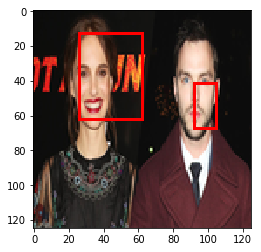

In [62]:
plot_box1(d, "nata.jpg")

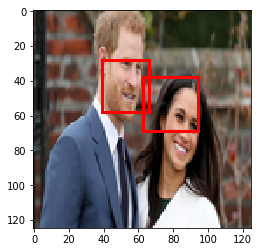

In [66]:
plot_box1(d, "megan.jpg")

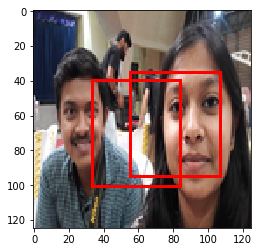

In [70]:
plot_box1(d, "rakesh.jpg")

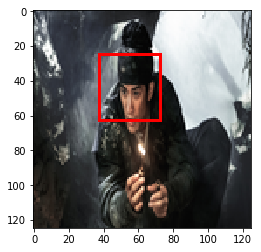

In [78]:
plot_box1(d, "f.jpg")

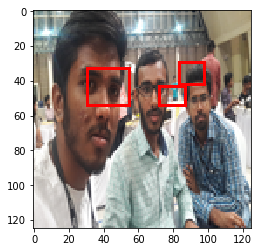

In [54]:
plot_box1(d, "detect.jpg")

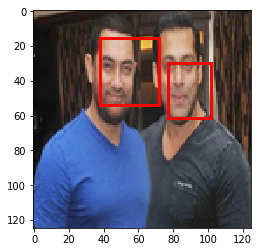

In [26]:
plot_box1(d, "face.jpg")

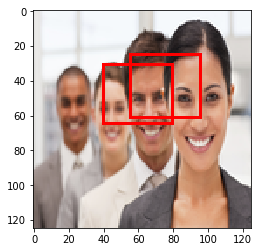

In [83]:
plot_box1(d, "ppl.jpg")

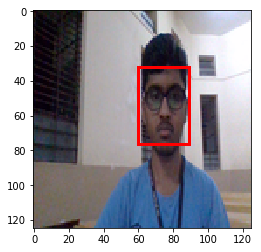

In [26]:
plot_box1(d, "me.jpg")

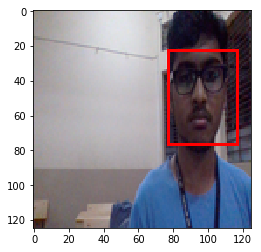

In [39]:
plot_box1(d, "me1.jpg")

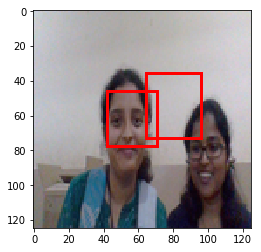

In [92]:
plot_box1(d, "sam.jpg")